# Additive Gaussian Processes

One central limitation of Gaussian Processes (GPs) {cite}`rasmussen2003gaussian` with conventional kernels is that they scale poorly with increasing input dimensions. Naively chosen covariance functions, such as those of the RBF family (e.g. EQ or Matern).


Additive GPs remedy this issue by using single-input covariances, and combining these to create interaction terms of all orders.

$$\begin{align}
k_{\text{add}}(x, x') = \sum_{d = 1}^D \sigma^2_d k_{\text{add}, d}(x, x')
\end{align}$$

$$\begin{align}
k_{\text{add}, d}(x, x') &= \sum_{1 \leq i_1 < ... < i_d \leq D} \prod_{n = 1}^N k_{i_n}(x_{i_n}, x_{i_n}') \\
&= \sum_{1 \leq i_1 < ... < i_d \leq D} \prod_{n = 1}^N z_{i_n}
\end{align}$$

In [416]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

<div class="lemma">
    
**Definition (Newton-Girard formulae)** Let $z_1, ..., z_D \in \mathbb{R}$, $s_k$ be the power sum
    
$$\begin{align}
p_K(z_1, ..., z_D) = P_K = \sum_{d = 1}^D z_d^k.
\end{align}$$
    
and $s_K$ be the symmetric polynomial of order $K < D$, written as

$$\begin{align}
s_K(z_1, ..., z_D) = S_K = \sum_{1 \leq i_1 < ... < i_K \leq K} \prod_{k = 1}^K z_{i_k}.
\end{align}$$
    
The following recursive relation, known as the Newton-Girard formula, holds
    
$$\begin{align}
S_K &= \frac{1}{K} \sum_{k = 1}^{K} (-1)^{k-1} S_{K - k} P_k,
\end{align}$$
 
where we have defined $S_0 = 1$.
    
</div>
<br>

Several proofs of the Newton-Girard formulae are available. Here we present a short one, adapted from [planetmath.org](https://planetmath.org/ProofOfNewtonGirardFormulaForSymmetricPolynomials).

<details class="proof">
<summary>Derivation: Newton-Girard formulae</summary>
    
Starting from the polynomial
    
$$\begin{align}
f(x) &= \prod_{d = 1}^D (1 - z_d x)
\end{align}$$
    
and taking its derivative, we obtain
    
$$\begin{align}
f'(x) &= - f(x)\sum_{d = 1}^D \frac{z_d}{1 - z_d x} \\
      &= \phantom{-} f(x)\sum_{d = 1}^D \sum_{l = 0}^\infty (-1)^{l+1} z_d^{l + 1} x^l \\
      &= \phantom{-} f(x)\sum_{l = 0}^\infty (-1)^{l+1} P_{l + 1} x^l
\end{align}$$
    
Now, noting that the polynomial can also be written as
   
$$\begin{align}
f(x) &=  \sum_{d = 0}^D s_d(z_1, ..., z_D)~x^d \\
     &=  \sum_{d = 0}^D S_d~x^d,
\end{align}$$
    
we take a derivative of this expression to obtain
    
$$\begin{align}
f'(x) &= S_1 + 2S_2 x + ... + D S_D x^{D-1}.
\end{align}$$
    
    
Now equating the two expressions for the derivatives and rearranging to compare coefficients
    
$$\begin{align}
S_1 + 2S_2 x + ... + D S_D x^{D-1} &= \left[\sum_{d = 0}^D S_d~x^d \right] \left[\sum_{l = 0}^\infty (-1)^{l+1} P_{l + 1} x^l\right] \\
                                   &= \left[\sum_{d = 0}^D \sum_{l = 0}^\infty (-1)^{l+1} S_d P_{l + 1} x^{d + l}\right]\\
                                   &= \left[\sum_{n = 0}^\infty (S_n P_1 - ... + (-1)^n S_0 P_{n + 1}) x^n\right]
\end{align}$$
    
we obtain
    
$$\begin{align}
S_K &= \frac{1}{K} \sum_{k = 1}^{K} (-1)^{k-1} S_{K - k} P_k.
\end{align}$$

</details>
<br>

Using the Newton-Girard formula, we can efficiently compute the covariance function up to the desired level of interactions. For a $D$-dimensional problem, we can compute the first $K \leq D$ interactions in $\mathcal{O}(K^2)$ time. Further, we could also use high-order interactions if we so want, by taking differences of a low-order and a high-order interaction covariance.

## Implementation

In [39]:
import tensorflow as tf

class EQKernel(tf.Module):
    
    def __init__(self, lengthscale, dim, dtype, name='eq_kernel', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.dtype = dtype
        self.dim = dim
        
        self.log_lengthscale = np.log(lengthscale)
        self.log_lengthscale = tf.Variable(self.log_lengthscale,
                                           dtype=self.dtype)
        
        
    def __call__(self, x1, x2):
        
        assert self.dim < x1.shape[-1] == x2.shape[-1]
        
        diff = x1[:, None, self.dim] - x2[None, :, self.dim]
        exp = tf.exp(-0.5 * (diff / tf.exp(self.log_lengthscale)) ** 2)
        
        return exp

In [575]:
class AdditiveCovariance(tf.Module):
    
    def __init__(self, covs, variances, noise, dtype, name='addgp', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.dtype = dtype
        self.covs = covs
        self.dim = len(covs)
        
        self.log_variances = tf.Variable(np.log(variances),
                                         dtype=self.dtype)
        
        self.log_noise = tf.Variable(np.log(noise),
                                     dtype=self.dtype)
        
        
    def covariance_power_sums(self, x1, x2):
        
        covs = [cov(x1, x2) for cov in self.covs]
        covs = tf.stack(covs, axis=-1)
        
        powers = tf.range(1, self.dim + 1, dtype=self.dtype)
        
        cov_powers = covs[:, :, :, None] ** powers[None, None, None, :]
        cov_powers = tf.reduce_sum(cov_powers, axis=2)
        
        return cov_powers
        
        
    def __call__(self, x1, x2, Kmin=None, Kmax=None, add_noise=False):
        
        assert x1.shape[-1] == x2.shape[-1] == self.dim
        
        Kmin = 0 if Kmin is None else Kmin - 1
        Kmax = self.dim if Kmax is None else Kmax
        
        # Compute power sums up-front
        P = self.covariance_power_sums(x1, x2)
        
        # List of S matices to use for recursive Newton-Girard
        S = [tf.zeros(shape=(x1.shape[0], x2.shape[0]), dtype=self.dtype) \
             for i in range(self.dim + 1)]
        
        # S0 is 1 by defnition
        S[0] = tf.ones_like(S[0])
        
        # Add kernel contributions by Newton-Girard 
        for i in range(1, self.dim + 1):
            for k in range(i):
                
                S[i] = S[i] + (-1) ** k * S[i - k - 1] * P[:, :, k]
                
            S[i] = S[i] / i
            
        # Take out the first S array -- this was used only for the recursion
        S = tf.stack(S[Kmin+1:Kmax+1], axis=-1)
            
        # Multiply by variances and sum all orders
        cov = tf.einsum('nmd, d -> nm', S, tf.exp(self.log_variances)[Kmin:Kmax])
            
        if add_noise:
            cov = cov + tf.exp(self.log_noise) * tf.eye(cov.shape[0], dtype=dtype)
        
        return cov

### Sanity checking

To sanity check this implementation, we can compute the covariance using the Newton-Girard method and compare this with the direct (but inefficient) approach. The two methods should give identical answers, which in fact they do:

In [576]:
# Data type to use
dtype = tf.float64

# Number of dimensions to use
num_dim = 2

# Initialise first-order covariances
covs = [EQKernel(lengthscale=1.,
                    dim=i,
                    dtype=tf.float64)
        for i in range(num_dim)]

# Set variance for each order
variances = np.ones(shape=(num_dim,))

# Initialise additive covariance object
add_cov = AdditiveCovariance(covs=covs,
                             variances=variances,
                             noise=noise,
                             dtype=dtype)

# Create random data to pass through covariance
x1 = tf.convert_to_tensor(np.random.randn(5, 2), dtype=dtype)
x2 = tf.convert_to_tensor(np.random.randn(3, 2), dtype=dtype)

# Compute covariance using Newton Girard
newton_girard_cov = add_cov(x1, x2)

print(f'Covariance matrix via Newton-Girard\n{newton_girard_cov}\n')

# Compute covariance directly
direct_cov = covs[0](x1, x2) + covs[1](x1, x2) + \
             covs[0](x1, x2) * covs[1](x1, x2)

print(f'Covariance matrix via direct computation\n{direct_cov}\n')

Covariance matrix via Newton-Girard
[[1.40654993 1.52086829 0.96454287]
 [1.38776204 1.80784575 1.38973516]
 [0.62688464 1.05034699 0.68561191]
 [0.44074886 1.46054563 0.72076007]
 [1.02046848 1.53453428 2.09021818]]

Covariance matrix via direct computation
[[1.40654993 1.52086829 0.96454287]
 [1.38776204 1.80784575 1.38973516]
 [0.62688464 1.05034699 0.68561191]
 [0.44074886 1.46054563 0.72076007]
 [1.02046848 1.53453428 2.09021818]]



In [608]:
# Number of dimensions to use
num_dim = 2

# Initialise first-order covariances
covs = [EQKernel(lengthscale=1.,
                    dim=i,
                    dtype=tf.float64)
        for i in range(num_dim)]

# Set variance for each order
variances = np.array([1., 1e-1])

# Initialise additive covariance object
add_cov = AdditiveCovariance(covs=covs,
                             variances=variances,
                             noise=noise,
                             dtype=dtype)

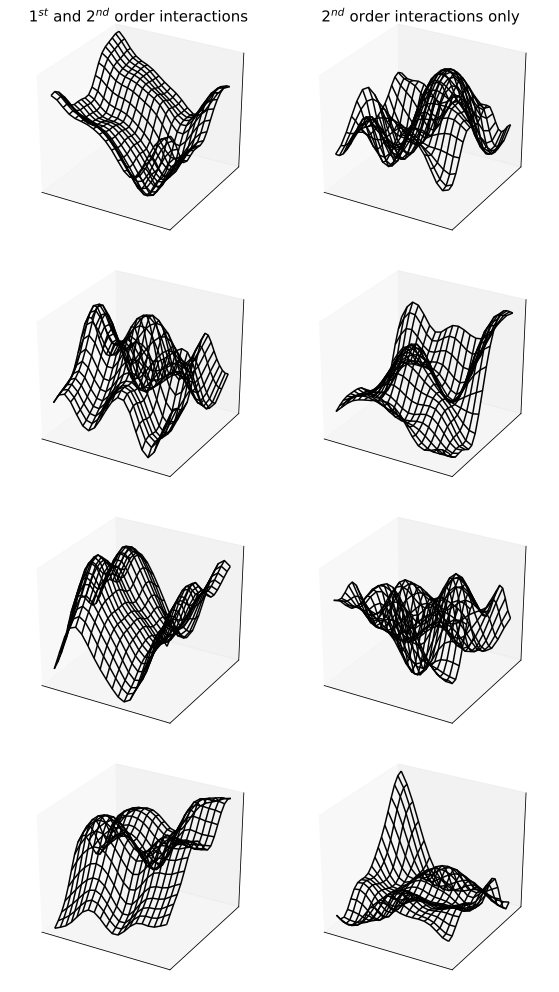

In [609]:
tf.random.set_seed(0)

num_points = 20
num_samples = 4

x = np.linspace(-3, 3, num_points)
x = np.stack(np.meshgrid(x, x), axis=2)
x_flat = tf.reshape(x, (num_points ** 2, 2))

x_flat = tf.convert_to_tensor(x_flat, dtype=dtype)

titles = ['$1^{st}$ and $2^{nd}$ order interactions',
          '$2^{nd}$ order interactions only']

fig = plt.figure(figsize=(8, 14))

for i in range(num_samples):
    
    for j, title in enumerate(titles):
    
        ax = fig.add_subplot(f'{num_samples}2{2*i+j+1}', projection='3d')

        if j == 0:
            cov = add_cov(x_flat, x_flat)
            
        else:
            cov = add_cov(x_flat, x_flat, Kmin=2, Kmax=2)
            
        cov = tf.reshape(cov, (num_points ** 2, num_points ** 2))
        cov_chol = tf.linalg.cholesky(cov + 1e-6 * tf.eye(cov.shape[0], dtype=dtype))

        sample = cov_chol @ tf.random.normal(shape=(num_points ** 2, 1), dtype=dtype)
        sample = tf.reshape(sample, (num_points, num_points))

        if i == 0:
            ax.set_title(title, fontsize=15)
            
        ax.plot_wireframe(x[:, :, 0], x[:, :, 1], sample, color='k')
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
plt.tight_layout()
plt.show()

We observe that the function draws from the GP with an additive covariance look like the sum of three functions, one in $x_1$ another in $x_2$ and a last one in $x_1, x_2$. On the other hand, the functions drawn from the GP with $2^{nd}$ order contributions only, look like a bivariate function in terms of both $x_1, x_2$. This suggests that additive covariances could be able to better describe data which depend on individual functions.

In [627]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def marginal_likelihood(x, y, covariance):
    
    dtype = y.dtype
    
    mean = tf.zeros_like(y, dtype=dtype)
    
    cov = covariance(x, x, add_noise=True)
    cov_chol = tf.linalg.cholesky(cov)
    
    distribution = tfp.distributions.MultivariateNormalTriL(loc=mean,
                                                            scale_tril=cov_chol)
    
    return distribution.log_prob(y)


def gp_pred_post(x, y, x_, covariance):
    
    Kxx = covariance(x, x, add_noise=True)
    Kxx_ = covariance(x, x_, add_noise=False)
    Kx_x = covariance(x_, x, add_noise=False)
    Kx_x_ = covariance(x_, x_, add_noise=True)
    
    mean = (Kx_x @ tf.linalg.solve(Kxx, y[:, None]))[:, 0]
    cov = Kx_x_ - Kx_x @ tf.linalg.solve(Kxx, Kxx_)
    
    return mean, cov

In [695]:
tf.random.set_seed(1)

num_data = 10

x_data = 2. * tf.random.uniform((num_data, 2), dtype=dtype) - 1.
y_data = tf.sin(2 * np.pi * x_data[:, 0]) + tf.sin(2 * np.pi * x_data[:, 1])

optimiser = tf.optimizers.Adam(lr=1e-2)

num_steps = 100

for i in range(num_steps):
    
    with tf.GradientTape() as tape:
        
        tape.watch(add_cov.trainable_variables)
        
        loss = - marginal_likelihood(x_data, y_data, add_cov)
        
    gradients = tape.gradient(loss, add_cov.trainable_variables)
    optimiser.apply_gradients(zip(gradients, add_cov.trainable_variables))

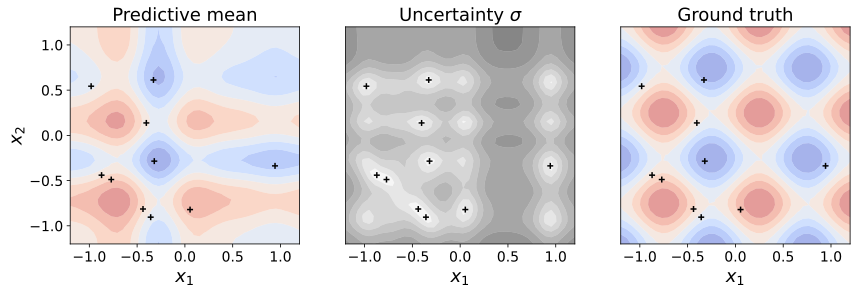

In [702]:
num_points = 40

x = np.linspace(-1.2, 1.2, num_points)
x = np.stack(np.meshgrid(x, x), axis=2)
x_flat = tf.reshape(x, (num_points ** 2, 2))

x_flat = tf.convert_to_tensor(x_flat, dtype=dtype)
y_true = tf.sin(2 * np.pi * x_flat[:, 0]) + tf.sin(2 * np.pi * x_flat[:, 1])
y_true = tf.reshape(y_true, (num_points, num_points))

pred_mean, pred_cov = gp_pred_post(x_data, y_data, x_flat, add_cov)

pred_mean = tf.reshape(pred_mean, (num_points, num_points))
pred_cov = tf.reshape(tf.linalg.diag_part(pred_cov), (num_points, num_points))

fig = plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.contourf(x[:, :, 0], x[:, :, 1], pred_mean, cmap='coolwarm', alpha=0.5)
plt.scatter(x_data[:, 0], x_data[:, 1], color='k', marker='+')
plt.xticks(np.linspace(-1, 1, 5), fontsize=14)
plt.yticks(np.linspace(-1, 1, 5), fontsize=14)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.title('Predictive mean', fontsize=18)

plt.subplot(132)
plt.contourf(x[:, :, 0], x[:, :, 1], pred_cov ** 0.5, cmap='binary', alpha=0.5)
plt.scatter(x_data[:, 0], x_data[:, 1], color='k', marker='+')
plt.yticks([])
plt.xticks(np.linspace(-1, 1, 5), fontsize=14)
plt.xlabel('$x_1$', fontsize=18)
plt.title('Uncertainty $\sigma$', fontsize=18)

plt.subplot(133)
plt.contourf(x[:, :, 0], x[:, :, 1], y_true, cmap='coolwarm', alpha=0.5)
plt.scatter(x_data[:, 0], x_data[:, 1], color='k', marker='+')
plt.yticks([])
plt.xticks(np.linspace(-1, 1, 5), fontsize=14)
plt.xlabel('$x_1$', fontsize=18)
plt.title('Ground truth', fontsize=18)

plt.show()

## References

```{bibliography} ./references.bib
```